<a href="https://colab.research.google.com/github/NotSoCoolLikeYou/ros2bookcode/blob/master/GadenTools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. What is GadenTools?

**GadenTools** is a Python module that lets you access the results of [GADEN](https://github.com/MAPIRlab/gaden) simulations directly from your Python code. It eliminates the need to install and use ROS, which up until now has been the only way to interact with Gaden. The intention is for this API to create a more accessible way for researchers to leverage existing resources of high fidelity gas dispersion simulations.

In this notebook you will learn how to use this API programatically, and see some use cases like examples of interesting data visualizations that can be generated with it, how to play back simulations in real time, or how to implement a simple source localization algorithm.

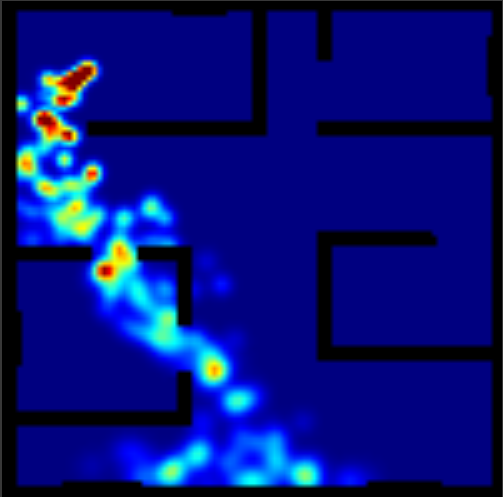 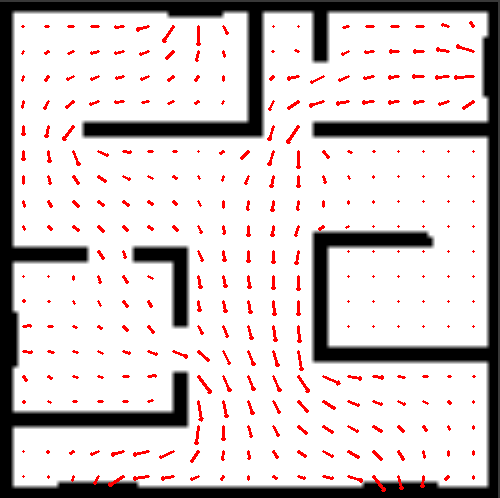
<center><i>Figure 1. Left, an example of a horizontal slice of the gas concentration in a house as a heatmap. Right, airflow's vector field of the same house.</i></center>

#2. Getting started

First thing one needs to do is install the module. The code is available in a github repository, linked in the cell below. If installing locally, please note that it was coded using python3 and cython, and also requires numpy to be installed in your device.

In [ ]:
!pip install git+https://github.com/MAPIRlab/GadenTools

Once the module is installed, one can import the relevant classes as follows. The two most important classes are `Simulation` and `Vector3`:

* The `Simulation` class is the core of this module, and serves as the main point of interaction. We will see what can be done with it shortly.

* The `Vector3` class simply implements a 3-dimensional vector of floating point numbers, with support for basic arithmetical operations and some extra utility functions. The `Simulation` class uses `Vector3` internally, but you might need to import it separately as well, as it is also used to specify points at which to query the simulation.

In [ ]:
from gadentools.Simulation import Simulation
from gadentools.Utils import Vector3

Let's also import some other things to create visualizations in this notebook:

In [ ]:
#notebook widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from gadentools.Utils import block
import numpy
import cv2
from google.colab.patches import cv2_imshow # for image display
from IPython.display import clear_output

def vector3Round(vec):
  return [round(vec.x,2), round(vec.y,2), round(vec.z,2)]

##2.1 Simulation data
This module is versatile enough so you can use any GADEN simulation with it, including those you make yourself! However, since dealing with Gaden could be complex for inexperienced users and requires the installation of additional software, we include here some resources of existing simulations. The code cells below can be used to access two sample simulations inside the colab environment, downloaded directly from Google Drive. Use these to try out the API's functionality throughout the notebook.

For a more extense repository of simulation data you can check out [the VGR dataset](https://mapir.isa.uma.es/mapirwebsite/?p=1708).

In [ ]:
!pip install -U -q PyDrive

In [ ]:
#### Choose one of these files ####
#file_id = '1-EKTTM7pfHCNZvkV5wCeDeJ_zUXqWiSp' #House01 -- VGR sample
file_id = '1nR9aQhZO5b6wybS5CbRfMwGTDJy54Jup' #Exp_C

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Download Zip
print ("Downloading file")
myzip = drive.CreateFile({'id': file_id})
myzip.GetContentFile('data')

# 3. Unzip
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('data', 'r')
zip_ref.extractall('DATA/')
zip_ref.close()

print("Done!")

##2.2 Accessing a Simulation

You can access the data in a given simulation by creating a `Simulation` object, which will serve as the programatic interface. The `Simulation` object's constructor takes two `string` arguments:

* the path to the simulation folder, and
* the path to the OccupancyGrid file.

For example:

In [ ]:
sim = Simulation("/content/DATA/Exp_C/FilamentSimulation_gasType_0_sourcePosition_1.75_8.60_0.50", \
                 "/content/DATA/Exp_C/OccupancyGrid3D.csv")

Once the `Simulation` object has been created, you can query it to obtain different types of information through the methods defined in the `Simulation` class. To see a list of the available public methods, their description, and their arguments you can use:

In [ ]:
help(Simulation)

For example, to programatically obtain the gas concentration and wind vector at a certain point in space $(x,y,z)$ in a given simulation iteration:  

In [ ]:
pointToQuery = Vector3(4.0, 4.0, 0.5)
iteration = 500
print("Gas Concentration at selected point:" + str( round(sim.getConcentration(iteration, pointToQuery), 2) ) + " ppm") #arguments are iteration, point. Returns ppm
print("3D Wind Vector at selected point:" + str( vector3Round( sim.getWind(iteration, pointToQuery) ) ) + " m/s") #arguments are iteration, point. Returns vector in m/s

You can use the following visualization to play around with this functionality. Use the "height" slider to select a 2D slice of the environment, and move through it with the "x" and "y" sliders to select a point to query.

In [ ]:
# Global variables
base_image = numpy.empty(2, float)
initiated = False
pointToQuery= Vector3(0,0,0)
h=0

### The simulation is queried here
def printValues():
  print("Gas Concentration at selected point:" + str( round(sim.getConcentration(500, pointToQuery),2) ) + " ppm") #arguments are iteration, point. Returns ppm
  wind = sim.getWind(500, pointToQuery)
  print("3D Wind Vector at selected point:" + str( vector3Round(wind) ) + " m/s") #arguments are iteration, point. Returns vector in m/s


##functions for visualization
def blend(image1:numpy.ndarray, image2:numpy.ndarray, mask:numpy.ndarray):
  mask = mask.astype(float)/255
  return mask * image2 + (1-mask) * image1

def showMapAndPlume(height:float, iteration:int, outWidget):
  global base_image
  global h
  h = height

  map = sim.generateConcentrationMap2D(iteration, height, True)
  map = map * (255.0/10)
  formatted_map = numpy.array(numpy.clip(map, 0, 255), dtype=numpy.uint8)
  formatted_map = cv2.cvtColor(formatted_map, cv2.COLOR_GRAY2BGR)

  base_image = numpy.full(formatted_map.shape, 255, numpy.uint8)
  block(map, base_image) #draw obstacles in black

  # draw the gas plume
  solid_color=numpy.empty_like(base_image)
  solid_color[:] = (0, 255, 0)
  base_image = blend(base_image, solid_color, formatted_map)

  #resize
  imageSizeFactor = 5
  newshape = (imageSizeFactor* map.shape[1], imageSizeFactor*map.shape[0])
  base_image = cv2.resize(base_image, newshape)

  global initiated
  initiated = True

def mapButton(height:float, iteration:int, outWidget):
  showMapAndPlume(height, iteration, outWidget)
  selectPoint(pointToQuery.x, pointToQuery.y, outWidget)

def selectPoint(x, y, outWidget):
  if not(initiated):
    return
  outWidget.clear_output(wait=True)
  im = numpy.copy(base_image)
  j = int( (x-sim.env_min.x) / (sim.env_max.x-sim.env_min.x) * im.shape[0] )
  i = int( (y-sim.env_min.y) / (sim.env_max.y-sim.env_min.y) * im.shape[1] )

  im=cv2.circle(im, (i,j), 4, (0,0,255), -1)
  with outWidget:
    im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cv2_imshow(im)
    global pointToQuery
    pointToQuery = Vector3(x,y,h)


### Setting up the interactive controls

# explicit output widget so that all the interact widgets print in the same output
out = widgets.Output(layout={'border': '1px solid black'})

# create the buttons and sliders
heightButton = interact_manual(mapButton,
                               height = widgets.FloatSlider(min=sim.env_min.z, max=sim.env_max.z, step=0.1, value=0),
         outWidget = fixed(out),
         iteration = fixed(500))
heightButton.widget.children[1].description = 'Select height'

interact(selectPoint, \
         x = widgets.FloatSlider(min=sim.env_min.x, max=sim.env_max.x, step=0.1, value=0), \
         y = widgets.FloatSlider(min=sim.env_min.y, max=sim.env_max.y, step=0.1, value=0),
         outWidget = fixed(out))

printButton=interact_manual(printValues)
printButton.widget.children[0].description = 'Print Values'


# Show and initial image with map and gas plume at height = 0.0
showMapAndPlume(h, 500, out)
selectPoint(0,0,out)
out


You can also access the ground truth source position through the `Simulation.source_position` field. Try to guess where it is using the following controls (no cheating!). Remember that you can change the height, but you have to reset the visualization by pressing the button.

Tip: Having a visualization of the airflow (see next section) might help.

In [ ]:
def makeSourcePositionGuess():
  guess = pointToQuery
  distance = (sim.source_position-pointToQuery).magnitude()
  print(str( round(distance,2) ) +"m away")
  if distance<1:
    print("Good guess! Actual position is "+str(vector3Round(sim.source_position)) )


# explicit output widget so that all the interact widgets print in the same output
out2 = widgets.Output(layout={'border': '1px solid black'})

heightButton2 = interact_manual(mapButton,
                               height = widgets.FloatSlider(min=sim.env_min.z, max=sim.env_max.z, step=0.1, value=0), outWidget=fixed(out2),
                                iteration = fixed(500))
heightButton2.widget.children[1].description = 'Select height'
interact(selectPoint, \
         x = widgets.FloatSlider(min=sim.env_min.x, max=sim.env_max.x, step=0.1, value=0), \
         y = widgets.FloatSlider(min=sim.env_min.y, max=sim.env_max.y, step=0.1, value=0), outWidget=fixed(out2))

guessButton=interact_manual(makeSourcePositionGuess)
guessButton.widget.children[0].description = 'Guess source position'


# Show and initial image with map and gas plume at height = 0.0
showMapAndPlume(h, 500, out2)

display(out2)

#3. Extracting Data as Images

##3.1 Basic Images

Beyond allowing simple access to the concentration and wind vector values at specific points of the environment, GadenTools also offers the ability to quickly visualize the data as images. This way, one can easily take advantage of one of the main perks of using simulated dispersion data: having access to the ground truth.

For example, the following code permits you to draw horizontal slices of the gas concentration in the environment as a heatmap. Use the "iteration" and "height" controls to select which data to show, and the "max_ppm" slider to select the gas concentration value (in parts per million) beyond which the image will show maximum intensity.

In [ ]:
def showHeatMap(height: float, max_ppm:float, iteration:int):
  map = sim.generateConcentrationMap2D(iteration, height, True) #get the information from the Simulation object

  map = map * (255.0/max_ppm) #max_ppm is the concentration value at which the image will saturate
  formatted_map=numpy.array(numpy.clip(map, 0, 255), dtype=numpy.uint8)

  heatmap = cv2.applyColorMap(formatted_map, cv2.COLORMAP_JET)

  block(map, heatmap) #draw obstacles in black

  imageSizeFactor = 5
  newshape= (imageSizeFactor* heatmap.shape[1], imageSizeFactor*heatmap.shape[0])

  heatmap = cv2.resize(heatmap, newshape)
  heatmap = cv2.rotate(heatmap, cv2.ROTATE_90_COUNTERCLOCKWISE)
  cv2_imshow(heatmap)


interact(showHeatMap,
                height=widgets.FloatSlider(min=sim.env_min.z, max=sim.env_max.z, step=0.1, value=sim.env_min.z+0.30), \
                max_ppm=widgets.FloatSlider(min=0, max=20, step=0.1, value=10), \
                iteration = widgets.IntSlider(min=0, max=2000, step=1, value=500));

Or, to generate a visualization of the airflow's vector field, so you can gain insight into how gas dispersion should behave:

In [ ]:
def showWindVectorField(height:float, arrowLength:float, spaceBetweenArrows:int):
  map=sim.generateWindMap2D(5, height, True)

  base_image=numpy.full(map.shape, 255, numpy.uint8)
  block(map, base_image) #draw obstacles in black

  imageSizeFactor = 5
  newshape=(imageSizeFactor* map.shape[1], imageSizeFactor*map.shape[0])
  base_image = cv2.resize(base_image, newshape)
  base_image = cv2.cvtColor(base_image, cv2.COLOR_GRAY2BGR)

  for i in range(0, map.shape[0], spaceBetweenArrows):
    for j in range(0, map.shape[1], spaceBetweenArrows):
      if isinstance(map[i,j], Vector3):
        offsetX = int(map[i,j].x * arrowLength)
        offsetY = int(map[i,j].y * arrowLength)
        cv2.arrowedLine(base_image,
                        (imageSizeFactor*j, imageSizeFactor*i),  #start of arrow
                        (imageSizeFactor*j + offsetY, imageSizeFactor*i + offsetX),  #end of arrow
                        (0,0,255), 2)


  base_image = cv2.rotate(base_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
  cv2_imshow(base_image)

interact(showWindVectorField,
                height=widgets.FloatSlider(min=sim.env_min.z, max=sim.env_max.z, step=0.1, value=sim.env_min.z+0.30), \
                arrowLength=widgets.FloatSlider(min=0, max=50, step=0.1, value=20), \
                spaceBetweenArrows=widgets.IntSlider(min=1, max=10, step=1, value=5));

##3.2 Image Processing on the Extracted Images

Using the previous gas concentration and/or airflow's vector field images as primitives, one can further process them to retrieve further information. As an example, one might want to find the contours of the gas plume in order to know the area affected by said gas:

In [ ]:
def showMap(height: float, max_ppm:float, contourThreshold:int):
  map = sim.generateConcentrationMap2D(500, height, True)
  map = map * (255.0/max_ppm) #max_ppm is the concentration value at which the image will saturate
  formatted_map=numpy.array(numpy.clip(map, 0, 255), dtype=numpy.uint8)

  imageSizeFactor = 5
  newshape = (imageSizeFactor* formatted_map.shape[1],imageSizeFactor*formatted_map.shape[0])
  formatted_map = cv2.resize(formatted_map, newshape)

  ret, thresh = cv2.threshold(formatted_map, contourThreshold, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  formatted_map = cv2.cvtColor(formatted_map, cv2.COLOR_GRAY2BGR) #change to bgr so we can draw the contours in color
  cv2.drawContours(formatted_map, contours, -1, (0,255,0), 3)

  formatted_map = cv2.rotate(formatted_map, cv2.ROTATE_90_COUNTERCLOCKWISE)
  cv2_imshow(formatted_map)
  print('Number of gas patches:', len(contours))


interact(showMap, height=widgets.FloatSlider(min=sim.env_min.z, max=sim.env_max.z, step=0.1, value=sim.env_min.z+0.30), \
                max_ppm=widgets.FloatSlider(min=0, max=20, step=0.1, value=10), \
                contourThreshold=widgets.IntSlider(min=0, max=255, step=1, value=40));

Or plot the concentration gradients in order to visualize how said concentration changes:

In [ ]:
from gadentools.Utils import makeSobelKernelX, makeSobelKernelY
from math import sqrt

def showGradientVectors(height:float, max_ppm:float, arrowLength:float, arrowTip:float, spaceBetweenArrows:int, imageSizeFactor):
  map = sim.generateConcentrationMap2D(500, height, True)
  map = map * (255.0/max_ppm) #max_ppm is the concentration value at which the image will saturate

  newshape=(imageSizeFactor* map.shape[1], imageSizeFactor*map.shape[0])
  base_image = numpy.array(cv2.resize( map, newshape), numpy.float32)

  sobelx = makeSobelKernelX(5)
  sobely = makeSobelKernelY(5)

  gradient_x = cv2.filter2D(base_image, -1, sobelx)
  gradient_y = cv2.filter2D(base_image, -1, sobely)
  base_image= cv2.cvtColor(base_image, cv2.COLOR_GRAY2BGR) #change to bgr so we can draw the contours in color

  for i in range(0, base_image.shape[0], spaceBetweenArrows):
    for j in range(0, base_image.shape[1], spaceBetweenArrows):
        offsetX = int(gradient_x[j,i] * arrowLength)
        offsetY = int(gradient_y[j,i] * arrowLength)
        if sqrt(offsetX*offsetX + offsetY*offsetY) > 0.5:
          cv2.arrowedLine(base_image,
                          (i, j),  #start of arrow
                          (i + offsetX, j + offsetY),  #end of arrow
                          (0,0,255),
                          thickness=2,
                          tipLength = arrowTip)


  base_image = cv2.rotate(base_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
  cv2_imshow(base_image)

interact_manual(showGradientVectors, height=widgets.FloatSlider(min=sim.env_min.z, max=sim.env_max.z, step=0.1, value=sim.env_min.z+0.30), \
                max_ppm=widgets.FloatSlider(min=0, max=20, step=0.1, value=10), \
                arrowLength=widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.2),
                arrowTip=widgets.FloatSlider(min=0.1, max=1, step=0.11, value=0.2),\
                spaceBetweenArrows=widgets.IntSlider(min=1, max=60, step=1, value=7), \
                imageSizeFactor = widgets.IntSlider(min=1, max=20, step=1, value=5));

#4. Playing Back the Simulation in Real Time

If you want to, it is still possible to play back the simulation data in real time, directly imitating the behaviour of the GADEN ROS nodes. To do so, you can use:

In [ ]:
sim.playSimulation(200, 0.5) #initial iteration, time interval
# your amazing code here, and
sim.stopPlaying()

If you use this, remember to call `stopPlaying()` once you are done, because otherwise the simulation will continue to be loaded in the background until all snapshots have been read.

While a simulation is being played, you should use the `getCurrentConcentration()` and `getCurrentWind()` versions of the functions to access the values of the simulation. If you instead use the versions that let you specify an iteration, like


```
sim.getConcentration(iteration:i, pointToQuery)
```


this will alter the internal state of the `Simulation` object, and the simulation will continue to play from iteration `i`, independently of where it was before the query.

##4.1 Real-time playback visualization

The following example shows a (somewhat choppy) video of the gas dispersion made from these 0.5s snapshots, being shown one after another in chronological order.

In [ ]:
import time
import threading

timeLimitSeconds = 20 #you can change this

height = float()
max_ppm = float()


def play():
  sim.playSimulation(0, 0.5)
  time_start = time.time()

  while (time.time()-time_start)<timeLimitSeconds:
    clear_output(wait=True)
    showHeatMap(height, max_ppm, sim.getCurrentIteration())
    time.sleep(0.5)

  sim.stopPlaying()

def setValues(h:float, ppm:float):
  global height
  global max_ppm
  height = h
  max_ppm = ppm

interact(setValues, h=widgets.FloatSlider(min=sim.env_min.z, max=sim.env_max.z, step=0.1, value=sim.env_min.z+0.30), \
                ppm=widgets.FloatSlider(min=0, max=20, step=0.1, value=10));
im = interact_manual(play);
im.widget.children[0].description = 'start';
display(im);

#5. Using the data with MRO algorithms

Now that we understand the basics and have seen the pretty pictures, let's answer the question on everyone's mind:

How would the code for a real algorithm look when using this interface to access the simulation data?


The next code snippet will show you just that. It is a fully in-notebook implementation of the classic Surge-Cast source localization algorithm, including a visualization of the robot's position and the gas distribution.

Some of the details of this implementation are kept deliberately very simple for the sake of clarity (for example, the obstacle avoidance behaviour is somewhat crude, and the state transition is completely myopic), but hopefully it will serve to give you a starting point for your own developments.

In [ ]:
vector3Up = Vector3(0,0,1)

def markPreviousPositions(previousPositions, initialRobotPosition, image):
  #trail
  for pos in previousPositions:
    j = int( (pos.x-sim.env_min.x) / (sim.env_max.x-sim.env_min.x) * image.shape[0] )
    i = int( (pos.y-sim.env_min.y) / (sim.env_max.y-sim.env_min.y) * image.shape[1] )
    image = cv2.circle(image, (i,j), 2, (0,0,0), -1)

  #starting point
  j = int( (initialRobotPosition.x-sim.env_min.x) / (sim.env_max.x-sim.env_min.x) * image.shape[0] )
  i = int( (initialRobotPosition.y-sim.env_min.y) / (sim.env_max.y-sim.env_min.y) * image.shape[1] )
  image = cv2.circle(image, (i,j), 4, (255, 0,0), -1)

  return image

def distanceFromSource(robotPosition):
  return (sim.source_position-robotPosition).magnitude()

def changeVelocityForObstacles(robotPosition, robotVelocity, deltaTime):
  # if path is blocked, try to go to the right, then to the left, and then back
  originalVelocity = robotVelocity

  newRobotPosition = robotPosition + robotVelocity * deltaTime
  if not sim.checkPositionForObstacles(newRobotPosition):
    robotVelocity = originalVelocity.cross(vector3Up).normalized() * originalVelocity.magnitude()
  newRobotPosition = robotPosition + robotVelocity * deltaTime

  if not sim.checkPositionForObstacles(newRobotPosition):
    robotVelocity = -originalVelocity.cross(vector3Up).normalized() * originalVelocity.magnitude()
  newRobotPosition = robotPosition + robotVelocity * deltaTime

  if not sim.checkPositionForObstacles(newRobotPosition):
    robotVelocity = -originalVelocity

  return robotVelocity

def surge_cast():
  #starting settings
  updateInterval = 0.5
  sim.playSimulation(500, updateInterval)
  initialRobotPosition=Vector3(3.5, 3, 0.5)
  robotPosition=initialRobotPosition
  robotSpeed = 2
  hitThreshold = 0.2

  #aux variables for the casting phase
  cast_timer=0
  castDirectionMultiplier = 1
  baseCastLength = 0.2
  currentCastLength = baseCastLength

  previousRobotPositions=[] #for drawing the trail

  #keep our own internal timer so that the simulation parameters are framerate-independent
  simulationTime = 0
  deltaTime=0.1
  timeLimitSeconds = 100

  while simulationTime<timeLimitSeconds and distanceFromSource(robotPosition)>0.5:
    if not sim.checkPositionForObstacles(robotPosition):
      print("Something went wrong! The robot is in a wall!")
      break;
    previousRobotPositions.append(robotPosition)
    outText.clear_output(wait=True)

    concentration = sim.getCurrentConcentration(robotPosition)
    #hit -> surge
    if concentration > hitThreshold and simulationTime-cast_timer>deltaTime:
      robotVelocity = -sim.getCurrentWind(robotPosition).projectOnPlane(vector3Up).normalized() * robotSpeed
      currentCastLength = baseCastLength
      with outText:
        print("Current state: Surge")
    #miss -> cast
    else:
      robotVelocity = sim.getCurrentWind(robotPosition).projectOnPlane(vector3Up).cross(vector3Up).normalized() * robotSpeed * castDirectionMultiplier
      with outText:
        print("Current state: Cast")
      if simulationTime-cast_timer>currentCastLength:
        castDirectionMultiplier *= -1
        cast_timer = simulationTime
        currentCastLength += baseCastLength

    #obstacle handling
    robotVelocity = changeVelocityForObstacles(robotPosition, robotVelocity, deltaTime)
    robotPosition += robotVelocity * deltaTime

    #visualization
    showMapAndPlume(0.5, sim.getCurrentIteration(), outImage)
    global base_image
    base_image = markPreviousPositions(previousRobotPositions, initialRobotPosition, base_image)
    selectPoint(robotPosition.x, robotPosition.y, outImage)

    simulationTime += deltaTime
    time.sleep(updateInterval)


  if distanceFromSource(robotPosition)<=0.5:
    with outText:
      print("Sucess!")
  sim.stopPlaying()


outImage = widgets.Output()
outText = widgets.Output()
interact_manual(surge_cast)
display(outText)
display(outImage)

You might observe that the robot has a bit of trouble regaining the gas plume after a casting phase. This is mostly because it restarts a surge as soon as it gets a gas hit, which is not in the middle of the plume, but instead at the very edge, and thus it often ends up quickly leaving the plume again.

Can you think of a way to mitigate this problem? Have a go at modifying the code above, and see how well you can get it to work!